## Implementation of Convolutional Neural Network
Prepared by: Prof. Seth H. Huang


Import required libraries and fetch the data:

In [1]:
pip install yfinance pandas numpy matplotlib scikit-learn torch

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [70]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, Dense, Flatten

# Download historical energy prices (e.g., crude oil) using the Yahoo Finance API
symbol = "SPY"  # Crude oil futures
start_date = "2010-01-01"
end_date = "2022-12-31"

data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [71]:
def generate_technical_indicators(df):
    # Example indicators: simple moving average (SMA) and relative strength index (RSI)
    # Adjust window sizes for the indicators as needed
    sma_window = 10
    rsi_window = 14

    df["SMA"] = df["Close"].rolling(window=sma_window).mean()
    delta = df["Close"].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    return df

data = generate_technical_indicators(data)

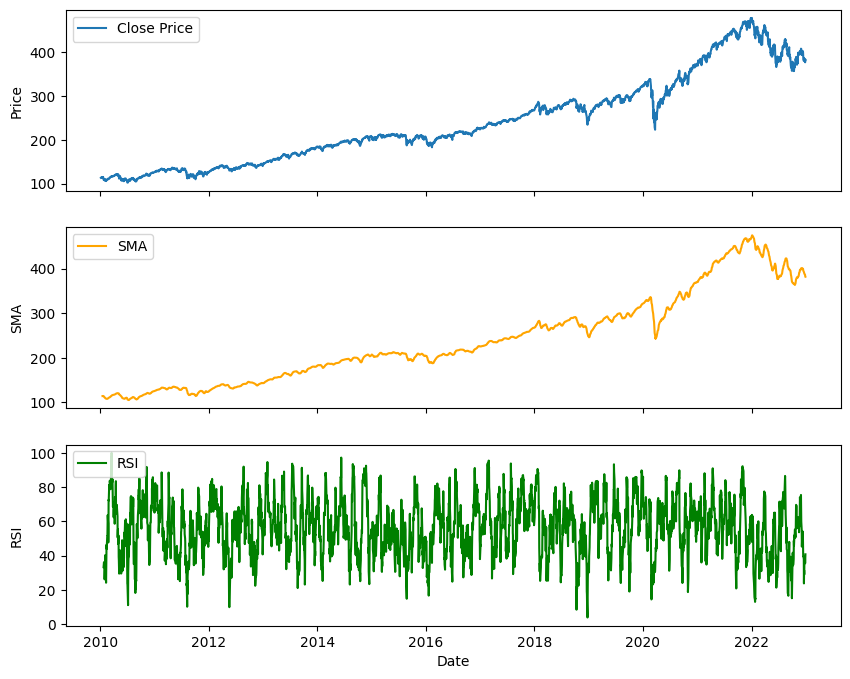

In [72]:
def plot_technical_indicators(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
    ax1.plot(df["Close"], label="Close Price")
    ax1.set_ylabel("Price")
    ax1.legend(loc="upper left")

    ax2.plot(df["SMA"], label="SMA", color="orange")
    ax2.set_ylabel("SMA")
    ax2.legend(loc="upper left")

    ax3.plot(df["RSI"], label="RSI", color="green")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("RSI")
    ax3.legend(loc="upper left")

    plt.show()

plot_technical_indicators(data)

In [73]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Drop rows with NaN values and reset the index
data = data.dropna().reset_index(drop=True)

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Close", "SMA", "RSI"]])

# Define the lookback period for input data
lookback = 30

# Generate input (X) and output (y) sequences
X, y = [], []
for i in range(len(scaled_data) - lookback):
    X.append(scaled_data[i:i + lookback])
    y.append(scaled_data[i + lookback, 0])  # The target value is the closing price

X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

# Convert the data to PyTorch tensors
X_train, X_val, X_test = torch.FloatTensor(X_train), torch.FloatTensor(X_val), torch.FloatTensor(X_test)
y_train, y_val, y_test = torch.FloatTensor(y_train), torch.FloatTensor(y_val), torch.FloatTensor(y_test)

# Create DataLoader objects for easier batch processing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [86]:
import torch.nn as nn
import torch.optim as optim

# Define the EarlyStopping class
class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss >= self.best_loss:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), 'best_model.pt')
        print('Checkpoint saved')

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * lookback, 64)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose the input tensor dimensions
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

In [78]:
# Instantiate the model, criterion, optimizer, and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters())
early_stopping = EarlyStopping(patience=50)

# Train the model and store the loss values
train_losses = []
val_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}")

    early_stopping(val_loss, cnn_model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break

Epoch 1/100, Loss: 0.005690303362018927, Val Loss: 0.0017831920749813435
Checkpoint saved
Epoch 2/100, Loss: 0.00010008635645519948, Val Loss: 0.001188554370401107
Checkpoint saved
Epoch 3/100, Loss: 6.988064926420994e-05, Val Loss: 0.0010043877109637833
Checkpoint saved
Epoch 4/100, Loss: 6.513559748500612e-05, Val Loss: 0.0009211623839746608
Checkpoint saved
Epoch 5/100, Loss: 6.827324078829047e-05, Val Loss: 0.000923243326951706
EarlyStopping counter: 1 out of 50
Epoch 6/100, Loss: 6.200226885020654e-05, Val Loss: 0.0011646897419268498
EarlyStopping counter: 2 out of 50
Epoch 7/100, Loss: 5.966326655101844e-05, Val Loss: 0.0009198765937981079
Checkpoint saved
Epoch 8/100, Loss: 5.504096330235332e-05, Val Loss: 0.001137301532253332
EarlyStopping counter: 1 out of 50
Epoch 9/100, Loss: 5.91626921959687e-05, Val Loss: 0.0008695597896348772
Checkpoint saved
Epoch 10/100, Loss: 9.966751569894333e-05, Val Loss: 0.0012476325800889754
EarlyStopping counter: 1 out of 50
Epoch 11/100, Loss: 5

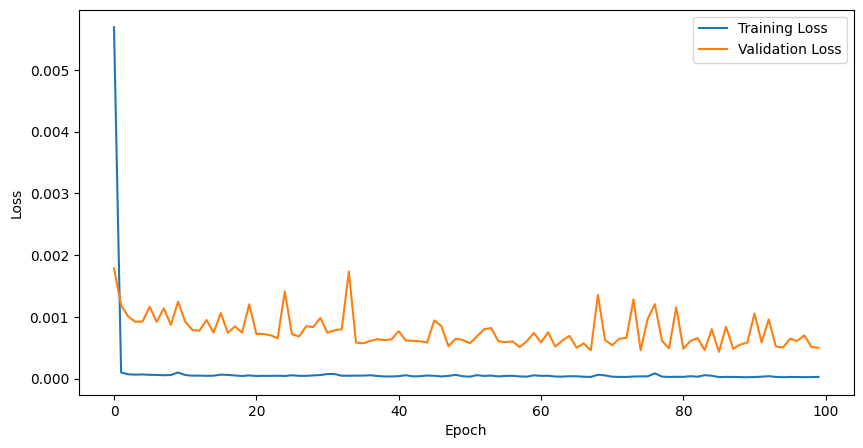

In [79]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

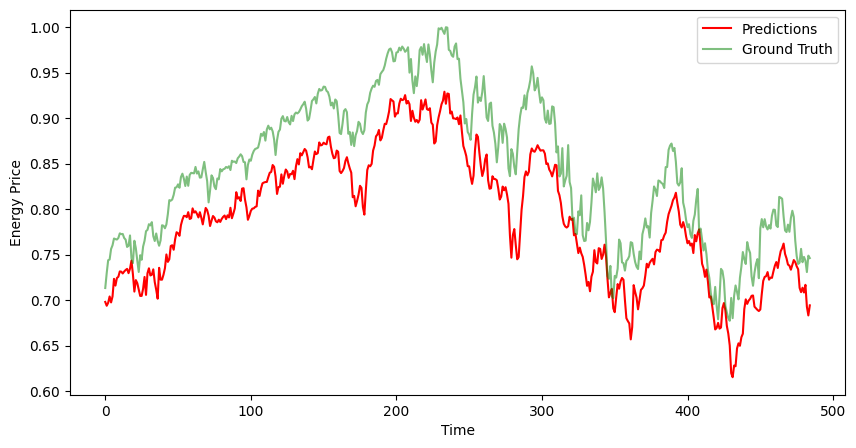

In [80]:
# Obtain model predictions on the test set
cnn_model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = cnn_model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        ground_truth.extend(targets.cpu().numpy())

# Plot the predictions against the ground truth
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', color='r')
plt.plot(ground_truth, label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

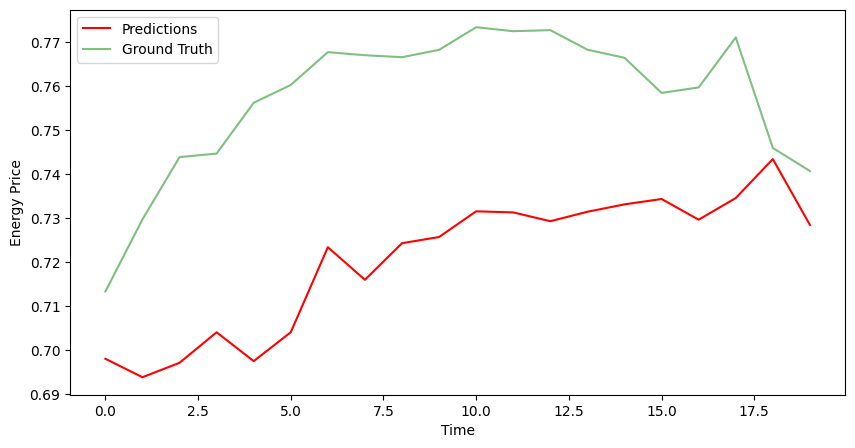

In [81]:
# Plot the predictions against the ground truth
plt.figure(figsize=(10, 5))
plt.plot(predictions[0:20], label='Predictions', color='r')
plt.plot(ground_truth[0:20], label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

## Now, perhaps that's not very intuitive. Let's see what the prediction accuracies are for up and down predictions

In [87]:
# Instantiate the model, criterion, optimizer, and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters())
early_stopping = EarlyStopping(patience=20)

# Train the model and store the loss values
train_losses = []
val_losses = []

num_epochs = 50

def calc_up_down_accuracy(outputs, targets):
    up_down_pred = torch.sign(outputs[1:] - outputs[:-1])
    up_down_target = torch.sign(targets[1:] - targets[:-1])
    accuracy = (up_down_pred == up_down_target).float().mean().item()
    return accuracy

# Initialize counters for training and validation up/down accuracy
train_up_down_accuracy_list = []
val_up_down_accuracy_list = []

# Modify the training loop to include up/down accuracy calculation
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0
    train_up_down_correct = 0
    train_samples = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
        train_samples += 1

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_up_down_accuracy = train_up_down_correct / train_samples
    train_up_down_accuracy_list.append(train_up_down_accuracy)

    # Validation
    cnn_model.eval()
    val_loss = 0
    val_up_down_correct = 0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

            val_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
            val_samples += 1

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_up_down_accuracy = val_up_down_correct / val_samples
    val_up_down_accuracy_list.append(val_up_down_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}, Train Up/Down Acc: {train_up_down_accuracy}, Val Up/Down Acc: {val_up_down_accuracy}")

    early_stopping(val_loss, cnn_model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break

Epoch 1/50, Loss: 0.0048760226287208434, Val Loss: 0.0023216188783408143, Train Up/Down Acc: 0.9513857209346663, Val Up/Down Acc: 0.49059138633310795
Checkpoint saved
Epoch 2/50, Loss: 0.00010829770956622949, Val Loss: 0.0022787268044339726, Train Up/Down Acc: 0.9745570077023036, Val Up/Down Acc: 0.463709669187665
Checkpoint saved
Epoch 3/50, Loss: 7.97360333077885e-05, Val Loss: 0.0017786376374715474, Train Up/Down Acc: 0.9747243968533797, Val Up/Down Acc: 0.45161289535462856
Checkpoint saved
Epoch 4/50, Loss: 7.068723141241157e-05, Val Loss: 0.0013697287554350623, Train Up/Down Acc: 0.9777373822642045, Val Up/Down Acc: 0.4475806411355734
Checkpoint saved
Epoch 5/50, Loss: 6.376233867625378e-05, Val Loss: 0.0011693628141529189, Train Up/Down Acc: 0.9791003994538751, Val Up/Down Acc: 0.4495967645198107
Checkpoint saved
Epoch 6/50, Loss: 6.222506927885443e-05, Val Loss: 0.0011313594745843147, Train Up/Down Acc: 0.9795547396364347, Val Up/Down Acc: 0.4556451514363289
Checkpoint saved
Epo

KeyboardInterrupt: 

###  It seems to be quite over-fitted. To prevent overfitting in your CNN model, we can apply several best practices, including regularization, dropout, data augmentation, and hyperparameter tuning. The following steps are what a quant strategist goes through to update the CNN architecture accordingly:

Add Dropout layers:
Dropout layers randomly set a fraction of input units to 0 at each update during training, which helps prevent overfitting by introducing some noise into the model.

Add Batch Normalization layers:
Batch Normalization normalizes the input features to have a mean of 0 and a variance of 1, which can help the model generalize better and speed up training.

Add weight decay to the optimizer:
Weight decay (L2 regularization) adds a penalty term to the loss function based on the weights' magnitude, which helps prevent overfitting by discouraging large weights.

Use data augmentation (if applicable):
Data augmentation can be applied when dealing with images or time series data. It generates new training samples by applying random transformations to the original data, which helps the model generalize better.

## can we improve the model?

In [88]:
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, dropout_rate=0):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * lookback, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.transpose(1, 2)  # Transpose the input tensor dimensions
        x = self.dropout1(self.relu1(self.bn1(self.conv1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout3(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x

In [89]:
# Instantiate the model, criterion, optimizer, and early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNNModel(dropout_rate=0.1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
early_stopping = EarlyStopping(patience=50)

# Train the model and store the loss values
train_losses = []
val_losses = []

num_epochs = 300

# Add scheduler.step() to the training loop
for epoch in range(num_epochs):
    # Training
    cnn_model.train()
    train_loss = 0
    train_up_down_correct = 0
    train_samples = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
        train_samples += 1

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_up_down_accuracy = train_up_down_correct / train_samples
    train_up_down_accuracy_list.append(train_up_down_accuracy)

    # Validation
    cnn_model.eval()
    val_loss = 0
    val_up_down_correct = 0
    val_samples = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

            val_up_down_correct += calc_up_down_accuracy(outputs.squeeze(), targets)
            val_samples += 1

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_up_down_accuracy = val_up_down_correct / val_samples
    val_up_down_accuracy_list.append(val_up_down_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}, Val Loss: {val_loss}, Train Up/Down Acc: {train_up_down_accuracy}, Val Up/Down Acc: {val_up_down_accuracy}")

    early_stopping(val_loss, cnn_model)
    if early_stopping.stop:
        print("Early stopping triggered")
        break

    # Update the learning rate scheduler
    scheduler.step()

Epoch 1/300, Loss: 0.034673699535245836, Val Loss: 0.015141487179789692, Train Up/Down Acc: 0.8245055952542265, Val Up/Down Acc: 0.492607519030571
Checkpoint saved
Epoch 2/300, Loss: 0.005295971895463135, Val Loss: 0.004461384181922767, Train Up/Down Acc: 0.8652765381504113, Val Up/Down Acc: 0.45564515329897404
Checkpoint saved
Epoch 3/300, Loss: 0.003871243445425701, Val Loss: 0.009448588360100985, Train Up/Down Acc: 0.8785719292264589, Val Up/Down Acc: 0.47647848539054394
EarlyStopping counter: 1 out of 50
Epoch 4/300, Loss: 0.00394259598581645, Val Loss: 0.0029207984243839746, Train Up/Down Acc: 0.884478339007203, Val Up/Down Acc: 0.45228493958711624
Checkpoint saved
Epoch 5/300, Loss: 0.003201735432220387, Val Loss: 0.008365214540390298, Train Up/Down Acc: 0.8862956896634169, Val Up/Down Acc: 0.48118278943002224
EarlyStopping counter: 1 out of 50
Epoch 6/300, Loss: 0.0028061786712422756, Val Loss: 0.0017152797809103504, Train Up/Down Acc: 0.8973672129738499, Val Up/Down Acc: 0.4274

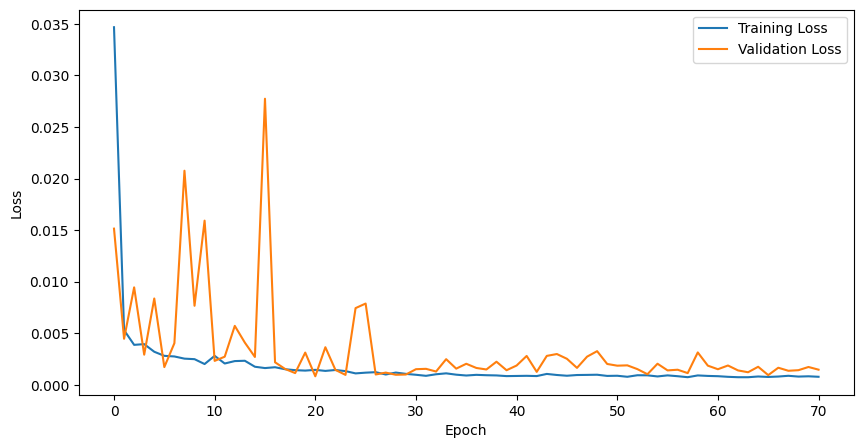

In [90]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

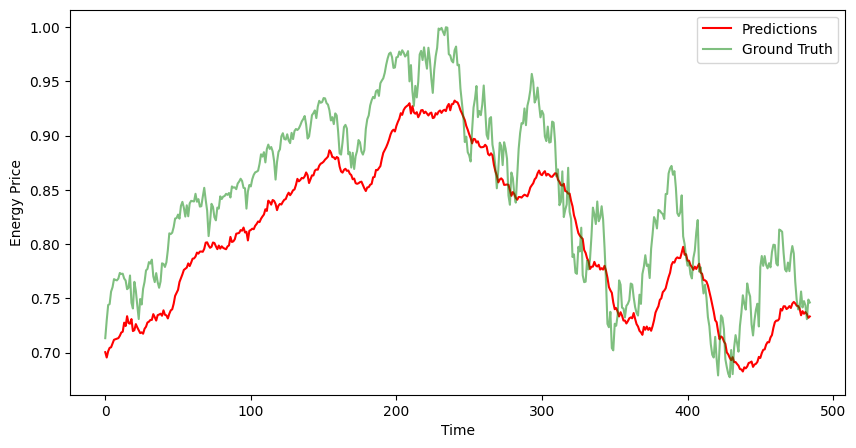

In [91]:
# Obtain model predictions on the test set
cnn_model.eval()
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = cnn_model(inputs)
        predictions.extend(outputs.squeeze().cpu().numpy())
        ground_truth.extend(targets.cpu().numpy())

# Plot the predictions against the ground truth
plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', color='r')
plt.plot(ground_truth, label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

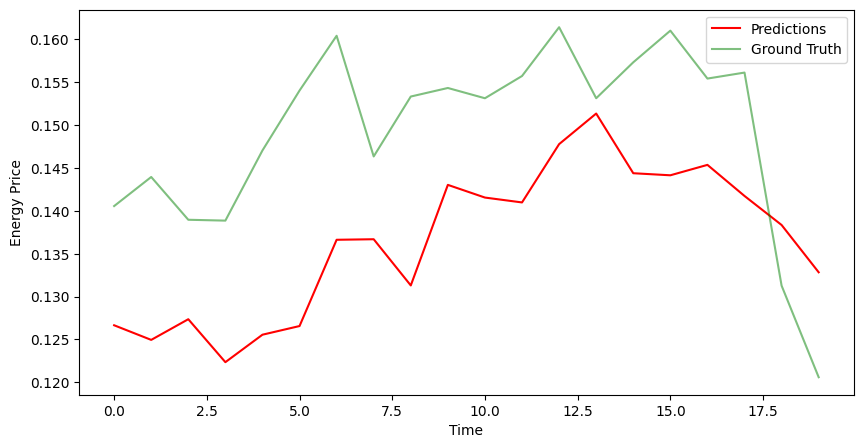

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(predictions[0:20], label='Predictions', color='r')
plt.plot(ground_truth[0:20], label='Ground Truth', color='g', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Energy Price')
plt.legend()
plt.show()

In [93]:
# Run the model on the validation dataset and store the predictions
predictions = []
ground_truth = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = cnn_model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        ground_truth.extend(targets.tolist())

# Calculate the percentage daily returns
percentage_daily_returns = [(ground_truth[i] - ground_truth[i - 1]) / ground_truth[i - 1] for i in range(1, len(ground_truth))]

# Calculate the model's up/down predictions and actual up/down movements
predicted_up_down = [1 if predictions[i] > predictions[i - 1] else -1 for i in range(1, len(predictions))]
actual_up_down = [1 if percentage_daily_returns[i] > 0 else -1 for i in range(len(percentage_daily_returns))]

# Initialize the profit and loss for correct and incorrect long and short predictions
correct_long_sum = 0
incorrect_long_sum = 0
correct_short_sum = 0
incorrect_short_sum = 0

# Iterate through the predictions and actual up/down movements
for i in range(len(predicted_up_down)):
    # If the prediction matches the actual movement
    if predicted_up_down[i] == actual_up_down[i]:
        # If the actual movement is up (positive return)
        if actual_up_down[i] == 1:
            correct_long_sum += percentage_daily_returns[i]
        # If the actual movement is down (negative return)
        else:
            correct_short_sum += -percentage_daily_returns[i]
    # If the prediction doesn't match the actual movement
    else:
        # If the actual movement is up (positive return)
        if actual_up_down[i] == 1:
            incorrect_long_sum -= percentage_daily_returns[i]
        # If the actual movement is down (negative return)
        else:
            incorrect_short_sum -= -percentage_daily_returns[i]

print(f"Profit from correct long predictions: {correct_long_sum}")
print(f"Loss from incorrect long predictions: {incorrect_long_sum}")
print(f"Profit from correct short predictions: {correct_short_sum}")
print(f"Loss from incorrect short predictions: {incorrect_short_sum}")


Profit from correct long predictions: 1.7181860919522678
Loss from incorrect long predictions: -2.1753890159103504
Profit from correct short predictions: 1.8531740542848159
Loss from incorrect short predictions: -1.43308866740193


### We can also add threshold for stronger predictions

In [96]:
# Set the prediction threshold
prediction_threshold = 0.005

# Initialize the profit and loss for correct and incorrect long and short predictions with the threshold
correct_long_sum_threshold = 0
incorrect_long_sum_threshold = 0
correct_short_sum_threshold = 0
incorrect_short_sum_threshold = 0

# Iterate through the predictions and actual up/down movements
for i in range(len(predicted_up_down)):
    # Check if the absolute difference between predictions is greater than the threshold
    if abs(predictions[i] - predictions[i - 1]) > prediction_threshold:
        # If the prediction matches the actual movement
        if predicted_up_down[i] == actual_up_down[i]:
            # If the actual movement is up (positive return)
            if actual_up_down[i] == 1:
                correct_long_sum_threshold += percentage_daily_returns[i]
            # If the actual movement is down (negative return)
            else:
                correct_short_sum_threshold += -percentage_daily_returns[i]
        # If the prediction doesn't match the actual movement
        else:
            # If the actual movement is up (positive return)
            if actual_up_down[i] == 1:
                incorrect_long_sum_threshold -= percentage_daily_returns[i]
            # If the actual movement is down (negative return)
            else:
                incorrect_short_sum_threshold -= -percentage_daily_returns[i]

print(f"Profit from correct long predictions with threshold: {correct_long_sum_threshold}")
print(f"Loss from incorrect long predictions with threshold: {incorrect_long_sum_threshold}")
print(f"Profit from correct short predictions with threshold: {correct_short_sum_threshold}")
print(f"Loss from incorrect short predictions with threshold: {incorrect_short_sum_threshold}")


Profit from correct long predictions with threshold: 0.31897857855473566
Loss from incorrect long predictions with threshold: -0.6321464396286947
Profit from correct short predictions with threshold: 0.9186139757474245
Loss from incorrect short predictions with threshold: -0.2027500812584456
